## Feature Extraction


In [26]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data'
                      ,header=None)

In [27]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values,df_wine.iloc[:, 0].values
X_train,X_test,y_train,y_test = \
    train_test_split(X,y,test_size=0.3,stratify=y,random_state=0)
# standardized the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std=sc.fit_transform(X_test)

In [28]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigan_vals, eigan_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n%s' % eigan_vals)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


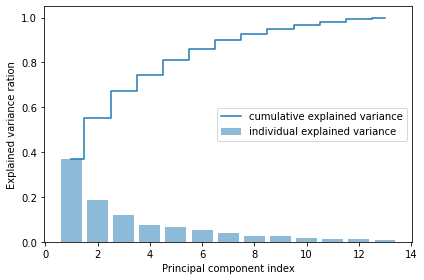

In [29]:
tot = sum(eigan_vals)
var_exp=[(i/tot) for i in
         sorted(eigan_vals,reverse=True)]
cum_var_exp=np.cumsum(var_exp)
import matplotlib.pyplot as plt
plt.bar(range(1,14),var_exp,alpha=0.5,align='center',
        label='individual explained variance')
plt.step(range(1,14),cum_var_exp,where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ration')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [30]:
eigan_pairs=[(np.abs(eigan_vals[i]),eigan_vecs[:,i])
             for i in range(len(eigan_vals))]
eigan_pairs.sort(key=lambda k: k[0],reverse=True)

In [31]:
w = np.hstack((eigan_pairs[0][1][:,np.newaxis],
               eigan_pairs[1][1][:,np.newaxis]))
print('Matrix W:\n',w)

Matrix W:
 [[-0.13724218 -0.50303478]
 [ 0.24724326 -0.16487119]
 [-0.02545159 -0.24456476]
 [ 0.20694508  0.11352904]
 [-0.15436582 -0.28974518]
 [-0.39376952 -0.05080104]
 [-0.41735106  0.02287338]
 [ 0.30572896 -0.09048885]
 [-0.30668347 -0.00835233]
 [ 0.07554066 -0.54977581]
 [-0.32613263  0.20716433]
 [-0.36861022  0.24902536]
 [-0.29669651 -0.38022942]]


In [32]:
X_train_std[0].dot(w)

array([ 2.38299011, -0.45458499])

In [33]:
X_train_pca= X_train_std.dot(w)

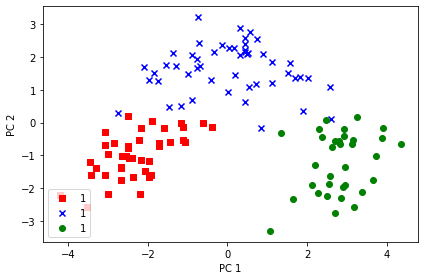

In [35]:
colors = ['r','b','g']
markers=['s','x','o']
for l, c, m in zip(np.unique(y_train),colors,markers):
    plt.scatter(X_train_pca[y_train==l,0],
                X_train_pca[y_train==l,1],
                c=c,label=1,marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [43]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X,y,classifier,test_idx=None,resolution=0.02):
    """

    :param X:
    :param y:
    :param classifier:
    :param test_idx:
    :param resolution:
    :return:
    """
    # set up marker generator and color map
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min,x1_max = X[:,0].min()-1,X[:,0].max()+1
    x2_min,x2_max = X[:,1].min()-1,X[:,1].max()+1
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                          np.arange(x2_min,x2_max,resolution))

    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,Z,alpha=0.3,cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())

    for idx,cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0],y=X[y==cl,1],
                    alpha=0.8,c=colors[idx],
                    marker=markers[idx],label=cl,
                    edgecolors='black')
        # highlight test examples
        if test_idx:
            X_test,y_test = X[test_idx,:],y[test_idx]

            plt.scatter(X_test[:,0],X_test[:,1],
                        c='', edgecolors='black',alpha=1.0,
                        linewidths=1,marker = 'o',
                        s=100,label='test set')


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
# initializing the PCA transformer and
# logistic regression estimator:
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr',
                        random_state=1,
                        solver='lbfgs')
# Dimensionality reduction:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test)
lr = lr.fit(X_train_pca,y_train)
plot_decision_regions(X_test_pca,y_train,classifier=lr)

MemoryError: Unable to allocate 9.03 GiB for an array with shape (403861486, 3) and data type float64